In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


In [546]:
dfDay = pd.read_csv('Surf-Temp-Day.csv')
dfNight = pd.read_csv('Surf-Temp-Night.csv')


In [547]:
dfDay = dfDay.drop(columns=['Latitude', 'Longitude'])
dfNight = dfNight.drop(columns=['Latitude', 'Longitude', 'Emissions M15'])

In [548]:
dfDay.head()

,Date,Emission M14,Land Surface Temperature Day
0,10/5/2023,0.49,0.0
1,10/6/2023,0.49,0.0
2,10/7/2023,0.49,0.0
3,10/8/2023,0.49,0.0
4,10/9/2023,0.49,0.0


In [549]:
dfNight.head()

,Date,Land Surface Temp Night
0,10/5/2023,298.4
1,10/6/2023,0.0
2,10/7/2023,0.0
3,10/8/2023,0.0
4,10/9/2023,0.0


In [550]:
dfDay['Date'] = pd.to_datetime(dfDay['Date'])
dfDay.set_index('Date', inplace=True)

dfNight['Date'] = pd.to_datetime(dfNight['Date'])
dfNight.set_index('Date', inplace=True)

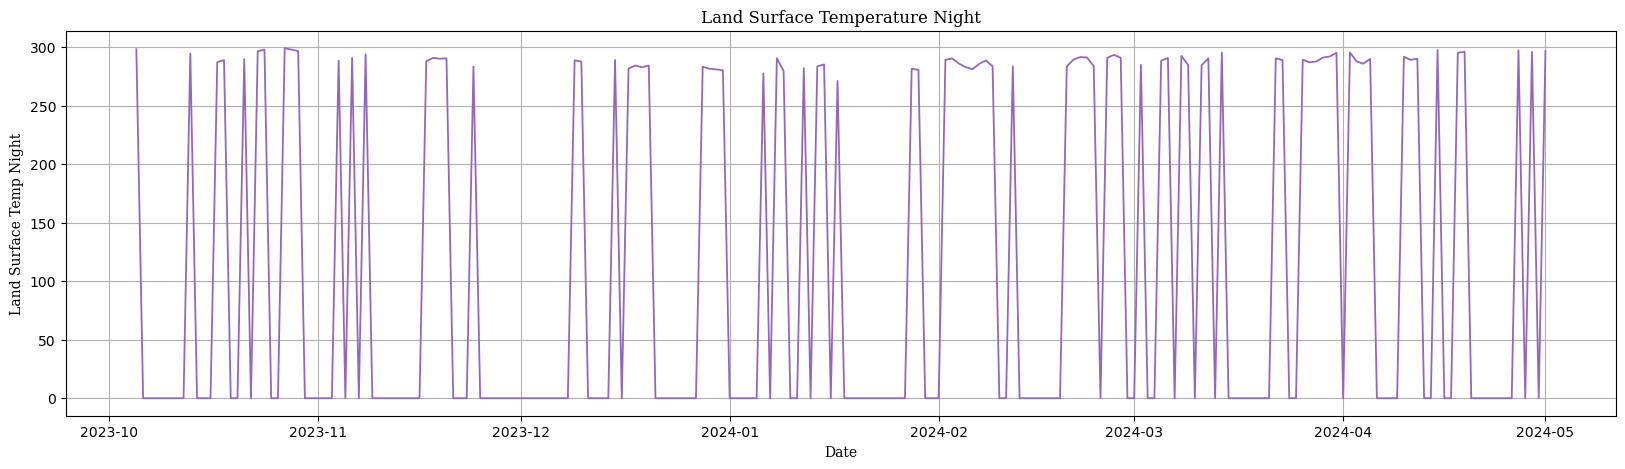

In [551]:
#Plot config
font_name = "Serif"

# Plot the time series
plt.figure(figsize=(20,5))
plt.plot(dfNight['Land Surface Temp Night'],linewidth=1.3, c='tab:purple')
plt.title('Land Surface Temperature Night', fontname=font_name)
plt.xlabel('Date', fontname=font_name)
plt.ylabel('Land Surface Temp Night', fontname=font_name)
plt.grid()
plt.show()

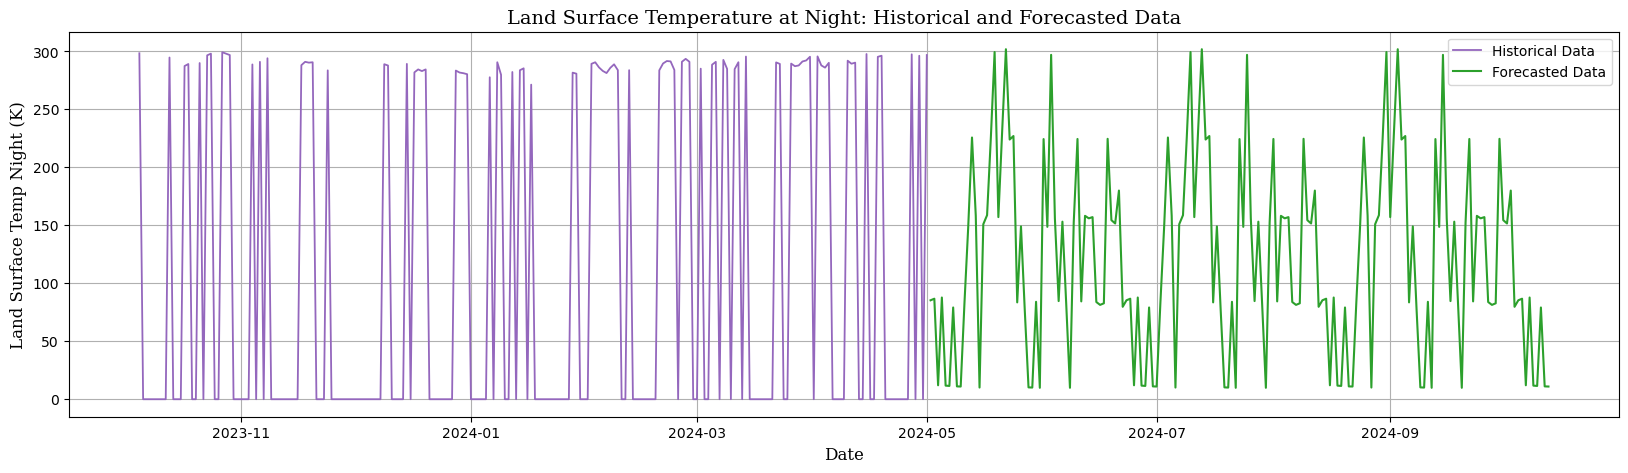

In [552]:
data_daily = dfNight.resample('D').interpolate()

# Fit the Exponential Smoothing model to the daily resampled data
model_daily = ExponentialSmoothing(data_daily['Land Surface Temp Night'], seasonal='add', seasonal_periods=52).fit()

# Forecast the next 5 months (approx. 150 days)
daily_forecast = model_daily.forecast(steps=165)

# Plot config
font_name = "Serif"

# Create a plot to compare the forecast with the actual data
plt.figure(figsize=(20, 5))

# Plot the historical (training) data
plt.plot(data_daily.index, data_daily['Land Surface Temp Night'], linewidth=1.3, color='tab:purple', label='Historical Data')
plt.plot(daily_forecast.index, daily_forecast, label='Forecasted Data', color='tab:green')

# Title and labels
plt.title('Land Surface Temperature at Night: Historical and Forecasted Data', fontsize=14, fontname=font_name)
plt.xlabel('Date', fontsize=12, fontname=font_name)
plt.ylabel('Land Surface Temp Night (K)', fontsize=12, fontname=font_name)

# Display legend and grid
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()



In [553]:
last_date = data_daily.index.max()  # Get the last date from the existing data
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=165, freq='D')  # 150 days daily frequency

# Step 2: Convert the forecasted values (which are in a Series) into a DataFrame
df_forecast = pd.DataFrame({
    'Date': forecast_dates,
    'Land Surface Temp Night': daily_forecast.values  # Forecasted values
})

In [554]:
df_forecast['Land Surface Temp Night'] = df_forecast['Land Surface Temp Night'].apply(lambda x: 0 if x < 180 else (x + 70 if x <= 250 else x))

In [555]:
data_daily.reset_index(inplace=True)

In [556]:
dfNight = pd.concat([data_daily, df_forecast], ignore_index=True)

In [557]:
dfNight.head()

,Date,Land Surface Temp Night
0,2023-10-05,298.4
1,2023-10-06,0.0
2,2023-10-07,0.0
3,2023-10-08,0.0
4,2023-10-09,0.0


In [558]:
df_final = pd.merge(dfDay, dfNight, on='Date', how='left')

In [559]:
df_final.tail()

,Date,Emission M14,Land Surface Temperature Day,Land Surface Temp Night
342,2024-09-29,0.490,0.00,0.00000
343,2024-09-30,0.976,316.42,294.60061
344,2024-10-01,0.980,311.64,0.00000
345,2024-10-02,0.978,313.26,0.00000
346,2024-10-03,0.980,309.36,0.00000


In [560]:
df_final.to_csv('LSTemp&Emis.csv', index=False)
